In [36]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import itertools

import pickle
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import collections

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.externals import joblib
from pipelineFunctions import *


%matplotlib inline


### Load training data from pickle

In [37]:
data = joblib.load('models/svc_01.pkl')
# data = joblib.load('models/clf_9869.pkl')
# svc = data['model']
svc = data['model']
config = data['config']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
X_scaler = config['X_scaler']
print(config)

{'hog_feat': True, 'pix_per_cell': 16, 'hist_bins': 16, 'orient': 11, 'spatial_feat': True, 'spatial_size': (16, 16), 'hog_channel': 'ALL', 'hist_feat': True, 'cell_per_block': 2, 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'color_space': 'YUV'}


## Find windows

In [38]:
triangle = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[450, None]),
      ]

# print(triangle)
# print(type(triangle))
# print(len(triangle))
image_size = (720, 1280)

# img = mpimg.imread('./test_images/test5.jpg')


# vertices = np.array([[(0, image_size[0]), (0,image_size[0]/2), (image_size[1], image_size[0]/2), (image_size[1], image_size[0])]], dtype=np.int32)
# vertices = vertices.reshape((-1,1,2))
# trinagle = cv2.polylines(img,[vertices],True,(255,0,0), 4)
# plt.imshow(trinagle)
windows = create_windows(triangle, image_size)

### Process frame

In [43]:
from pipelineFunctions import *
def process_frame(image, params):
    config, clf, all_windows = params['clf_config'], params['clf'], params['windows']

    if params['cache_enabled']:
        cache = process_frame.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])
        windows = itertools.chain(*all_windows)
    else:
        windows = itertools.chain(*all_windows)

    measurements = car_detect(image, clf, config, windows, params['decision_threshold'])
    current_heatmap = update_heatmap(measurements, image.shape)
    if not params['cache_enabled']:
        thresh_heatmap = current_heatmap
    else:
        cache['heatmaps'].append(current_heatmap)
        thresh_heatmap = sum(cache['heatmaps'])
    
    thresh_heatmap[thresh_heatmap < params['heatmap_threshold']] = 0
    cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)

    labels = label(thresh_heatmap)
    labeledBoxed = draw_labeled_bboxes(np.copy(image), labels)
    return labeledBoxed

def clear_cache():
    process_frame.cache = {
        'meas': None,
        'heatmaps': None,
        'frame_ctr': 0
    }

### Test on images

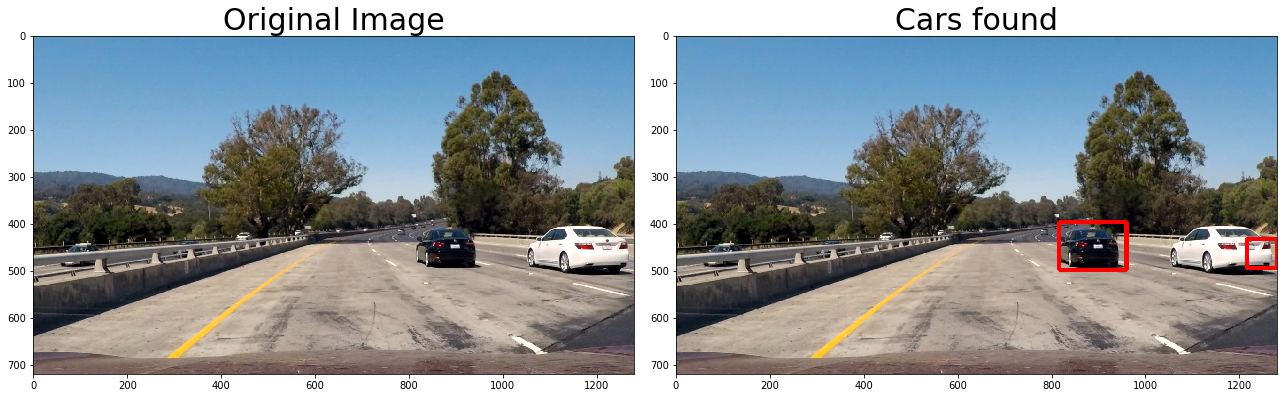

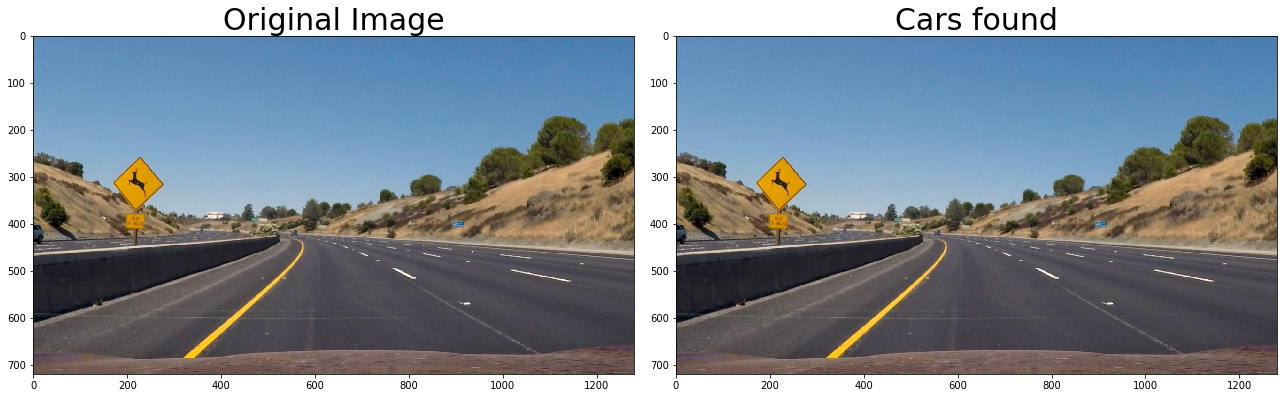

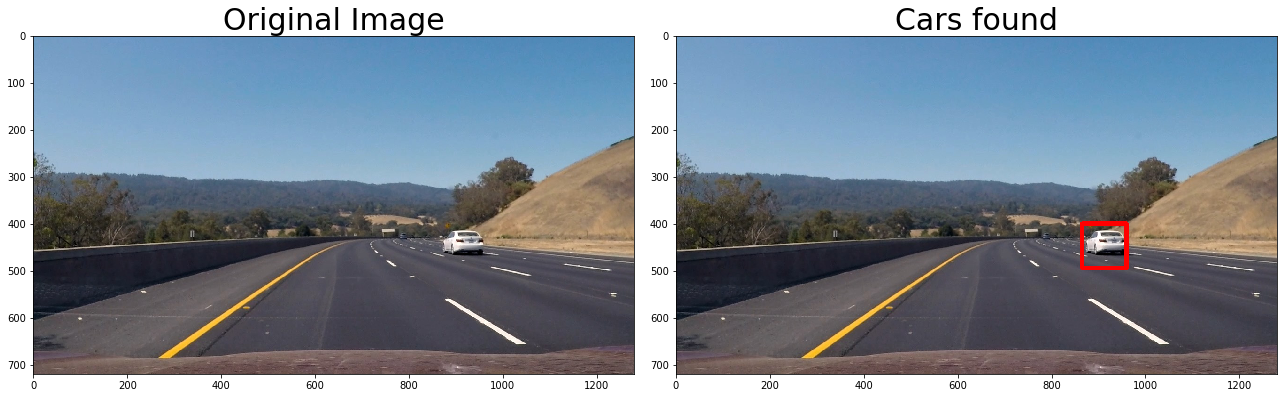

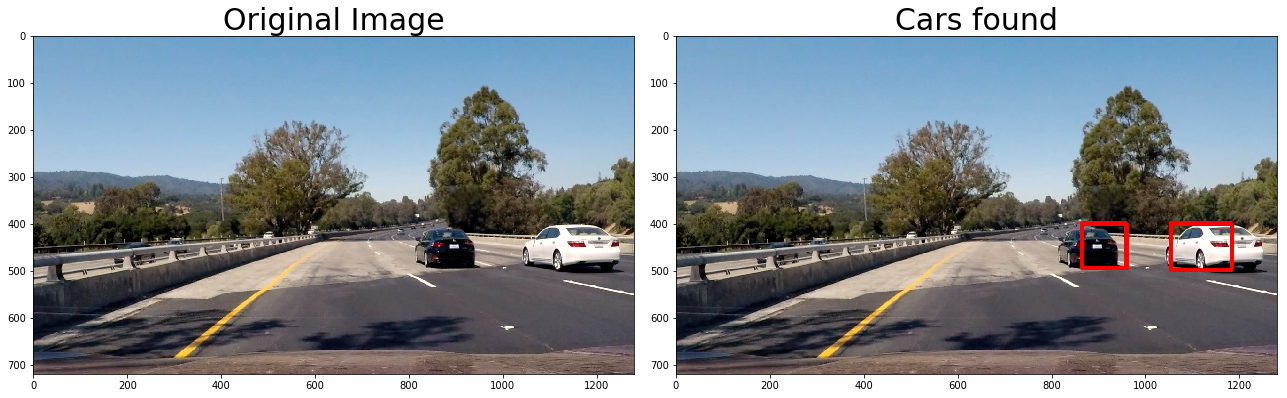

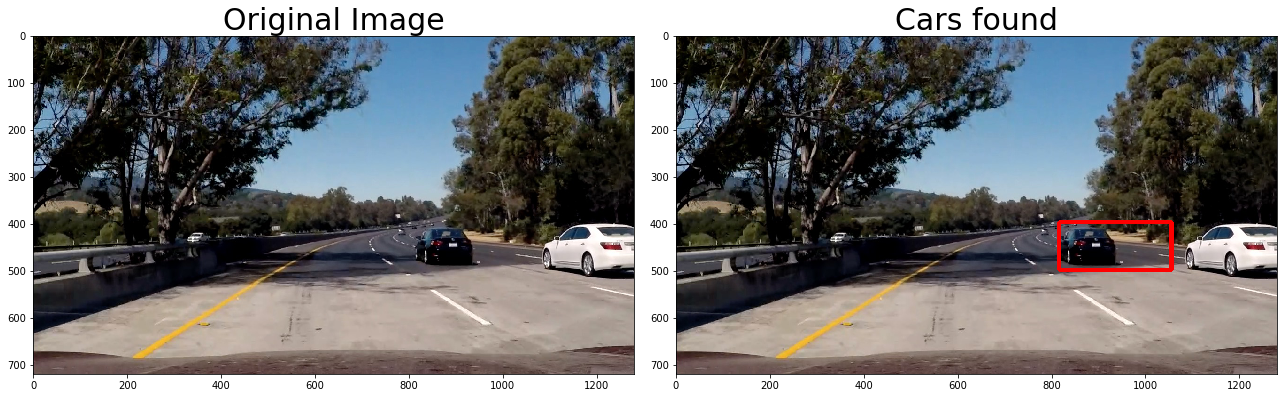

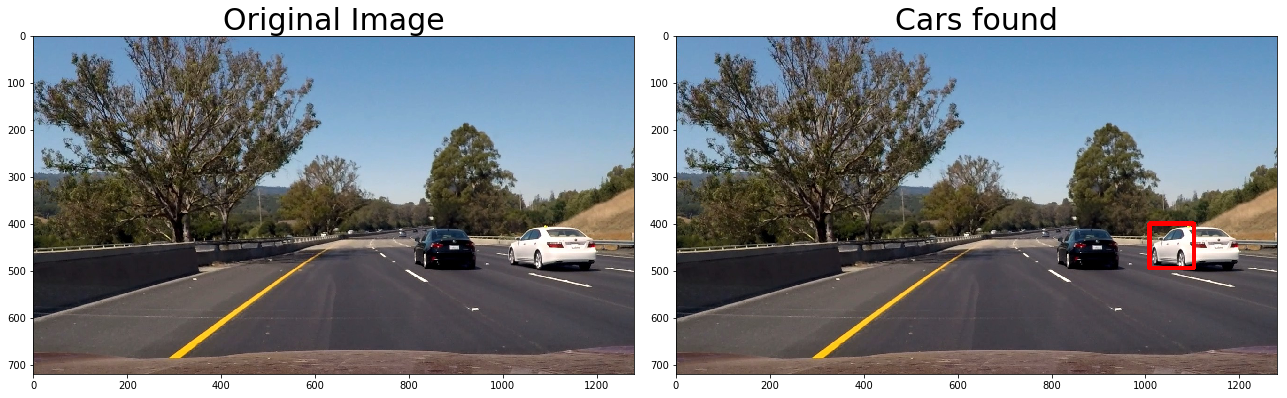

In [44]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = svc
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 6
params['heatmap_threshold'] = 1
params['decision_threshold'] = 1.5

for i in range(1,7):
    image = mpimg.imread('test_images/test{}.jpg'.format(i))
#     image = image.astype(np.float32)/255

    window_img = process_frame(image, params)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
#     plt.savefig('output_images/sliding_window.png', bbox_inches="tight")
    # plt.imshow(window_img)
    plt.show()
#     plt.imshow(im2)

### Test on video

In [85]:
from datetime import datetime
clear_cache()

params = {}
params['clf_config'] = config
params['clf'] = svc
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 150
params['heatmap_threshold'] = 20
params['decision_threshold'] = 0.95

t = time.time()

test_out_file = 'test_video_out.mp4'
# clip_test = VideoFileClip('test_video.mp4')
clip_test = VideoFileClip('project_video.mp4').subclip(10, 20)
# clip_test = VideoFileClip('project_video.mp4')

# clip_test_out = clip_test.fl_image(process_frame)
clip_test_out = clip_test.fl_image(lambda x: process_frame(x, params))

%time clip_test_out.write_videofile(test_out_file, audio=False)

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to process video.')
print(datetime.now().time())



[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


100%|█████████▉| 250/251 [01:40<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 38s, sys: 938 ms, total: 1min 39s
Wall time: 1min 41s
101.82147 Seconds to process video.
02:29:02.129352
